In [1]:
import pandas
from keras.models import Sequential,Model
from keras import losses
from keras.layers import Dense,Activation,LSTM,Lambda
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils.conv_utils import convert_kernel

from random import seed
from random import choice

%matplotlib inline 
#to plot inline in jupyter notebook  
import numpy as np #for array related 
import scipy.io as spio #to load data 
import cmath #for complex operations
import matplotlib.pyplot as plt #for plotting graphs
import math # for log 
from scipy.signal import hann, welch #for spectral analysis
import keras.backend as K
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.python.eager.context import context, EAGER_MODE, GRAPH_MODE

Using TensorFlow backend.


In [2]:
def plot_spec(spec_input,am_am = False,plot_label = None):
    
    # Spectral analyses of PA input and PA output
    Fs = 50e6
    N = np.min(np.array([1024,len(spec_input)]));
    pwin = hann(N);
    f_axis,spec_input_ps = welch(spec_input, Fs, window=pwin, nfft=N, return_onesided=False,scaling = 'spectrum',detrend=False)
    
    spec_input_ps_dB = [ 10*math.log10(abs(spec_input_ps[i])) for i in range(len(spec_input_ps)) ];

    # Plots
    f_axis = [f_axis[i]/1000000 for i in range(len(f_axis))]
    #plt.figure()
    plt.plot(f_axis,spec_input_ps_dB,label = plot_label)
    


In [3]:
#loading data from the file
#loading data from the file
mat = spio.loadmat('dpd_off_1.mat', squeeze_me=True)

op = mat['out']
ip = mat['in']
op = op/max(abs(op))

ip = ip/max(abs(ip))
print('Loaded data and scaled output')

pa_in_avg = np.mean(abs(ip))
pa_out_avg = np.mean(abs(op))
print(pa_in_avg)
print(pa_out_avg)

op = op*pa_in_avg/pa_out_avg

#ip = ip/max(abs(ip))
#op = op/(max(abs(op)))

print(max(abs(ip)))
print(max(abs(op)))


Loaded data and scaled output
0.28805246827736414
0.5332846593880599
1.0
0.5401476738669029


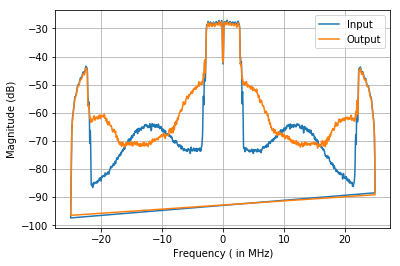

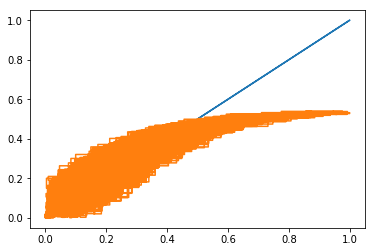

In [4]:
plt.figure()
plot_spec(ip,False,'Input')
plot_spec(op,False,'Output')
plt.legend()
plt.grid()
plt.xlabel('Frequency ( in MHz)')
plt.ylabel('Magnitude (dB)')

plt.show()

plt.figure()
plt.plot(np.abs(ip),np.abs(ip))
plt.plot(np.abs(ip),np.abs(op))
plt.show()


In [5]:
len(ip)

64701

In [6]:
def Convert2Feature(input):
	output = [(np.real(i),np.imag(i)) for i in input]
	return np.array(output).reshape(-1,2)

def Convert2Complex(input):
	return np.array([t[0]+1j*t[1] for t in np.array(input)])



	return (x_train,y_train,x_test,y_test)

def load_data(ip,op):
    train_len = 20000
    
    y_train = Convert2Feature(op[0:train_len])
    x_train = Convert2Feature(ip[0:train_len])
    x_test = Convert2Feature(ip)
    y_test = Convert2Feature(op)
    
    return (x_train,y_train,x_test,y_test)

In [7]:
x_train,y_train,x_test,y_test =  load_data(ip,op)

model = Sequential()
model.add(Dense(units=2000, input_dim=2))
model.add(Activation('relu'))
model.add(Dense(units=100))
model.add(Activation('tanh'))
model.add(Dense(units=10))
model.add(Activation('linear'))
model.add(Dense(units=2))

model.compile(loss='mean_squared_error',
              optimizer='rmsprop')

model.fit(x_train, y_train, epochs=75, batch_size=100, verbose=1)

#loss_and_metrics = model.evaluate(y_test, x_test, batch_size=100)

Epoch 1/75
20000/20000 [==============================] - 3s 167us/step - loss: 0.0045
Epoch 2/75
20000/20000 [==============================] - 2s 111us/step - loss: 0.0030
Epoch 3/75
20000/20000 [==============================] - ETA: 0s - loss: 0.002 - 2s 118us/step - loss: 0.0028
Epoch 4/75
20000/20000 [==============================] - 2s 108us/step - loss: 0.0027
Epoch 5/75
20000/20000 [==============================] - 2s 104us/step - loss: 0.0026
Epoch 6/75
20000/20000 [==============================] - 2s 95us/step - loss: 0.0025
Epoch 7/75
20000/20000 [==============================] - 3s 143us/step - loss: 0.0025
Epoch 8/75
20000/20000 [==============================] - 2s 114us/step - loss: 0.0025
Epoch 9/75
20000/20000 [==============================] - 2s 113us/step - loss: 0.0025
Epoch 10/75
20000/20000 [==============================] - 2s 114us/step - loss: 0.0025 0s -
Epoch 11/75
20000/20000 [==============================] - 2s 107us/step - loss: 0.0024
Epoch 12/75
2

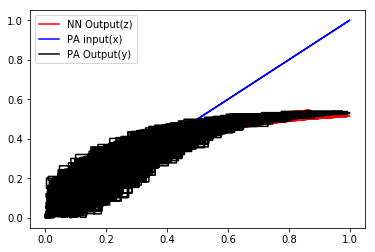

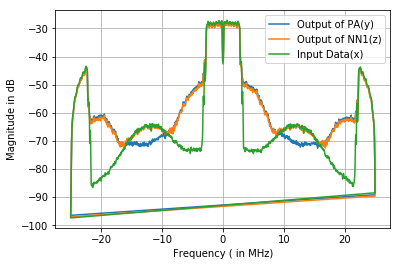

In [8]:
x_train,y_train,x_test,y_test =  load_data(ip,op)

classes = model.predict(x_test, batch_size=100)

plt.figure()
plt.plot(np.abs(Convert2Complex(x_test)), np.abs(Convert2Complex(classes)),c='r',label = 'NN Output(z)')
plt.plot(np.abs(Convert2Complex(x_test)),np.abs(Convert2Complex(x_test)),c='b',label = 'PA input(x)')
plt.plot(np.abs(Convert2Complex(x_test)),np.abs(Convert2Complex(y_test)),c='k',label = 'PA Output(y)')
plt.legend()
plt.show()


plt.figure()
#plt.title('Magnitude spectrum for alpha = '+str(0.1)+' mse = '+str(mse))
plot_spec((Convert2Complex((y_test))),plot_label='Output of PA(y)')
plot_spec((Convert2Complex(classes)),plot_label='Output of NN1(z)')
plot_spec(Convert2Complex(x_test),plot_label='Input Data(x)')
plt.ylabel('Magnitude in dB')
plt.xlabel('Frequency ( in MHz)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
model2 = Sequential()
model2.add(Dense(units=2000, input_dim=2))
model2.add(Activation('relu'))
model2.add(Dense(units=100))
model2.add(Activation('tanh'))
model2.add(Dense(units=10))
model2.add(Activation('linear'))
model2.add(Dense(units=2))

for layer in model.layers[:]:
    layer.trainable = False
    model2.add(layer)
    
model2.compile(loss='mean_squared_error',
              optimizer='adam')

model2.fit(x_train, x_train, epochs=75, batch_size=100, verbose=1)


Epoch 1/75
20000/20000 [==============================] - 6s 302us/step - loss: 0.0019
Epoch 2/75
20000/20000 [==============================] - 4s 178us/step - loss: 7.9074e-04
Epoch 3/75
20000/20000 [==============================] - 3s 172us/step - loss: 7.0757e-04
Epoch 4/75
20000/20000 [==============================] - 3s 167us/step - loss: 6.6123e-04
Epoch 5/75
20000/20000 [==============================] - 3s 164us/step - loss: 6.3252e-04
Epoch 6/75
20000/20000 [==============================] - 3s 167us/step - loss: 6.1287e-04
Epoch 7/75
20000/20000 [==============================] - 3s 159us/step - loss: 5.9923e-04
Epoch 8/75
20000/20000 [==============================] - 3s 159us/step - loss: 5.9009e-04
Epoch 9/75
20000/20000 [==============================] - 4s 184us/step - loss: 5.8279e-04
Epoch 10/75
20000/20000 [==============================] - 4s 186us/step - loss: 5.7749e-04
Epoch 11/75
20000/20000 [==============================] - 4s 192us/step - loss: 5.7532e-04
E

In [10]:
dpd = Sequential()
for layer in model2.layers[:-7]:
    dpd.add(layer)

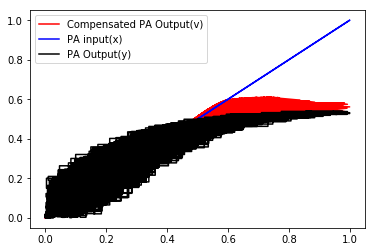

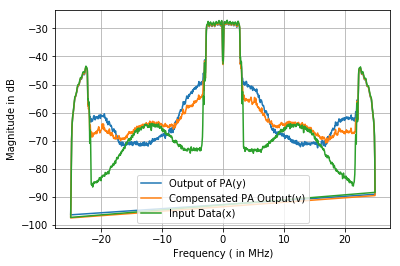

In [11]:
x_train,y_train,x_test,y_test =  load_data(ip,op)

classes = dpd.predict(x_test, batch_size=100)
classes = model.predict(classes, batch_size=100)
plt.figure()
plt.plot(np.abs(Convert2Complex(x_test)), np.abs(Convert2Complex(classes)),c='r',label = 'Compensated PA Output(v)')
plt.plot(np.abs(Convert2Complex(x_test)),np.abs(Convert2Complex(x_test)),c='b',label = 'PA input(x)')
plt.plot(np.abs(Convert2Complex(x_test)),np.abs(Convert2Complex(y_test)),c='k',label = 'PA Output(y)')
plt.legend()
plt.show()


plt.figure()
#plt.title('Magnitude spectrum for alpha = '+str(0.1)+' mse = '+str(mse))
#plot_spec(Convert2Complex(x_test),plot_label='Input to PA')
plot_spec((Convert2Complex((y_test))),plot_label='Output of PA(y)')
plot_spec(Convert2Complex(classes),plot_label='Compensated PA Output(v)')
plot_spec(Convert2Complex(x_test),plot_label='Input Data(x)')
plt.ylabel('Magnitude in dB')
plt.xlabel('Frequency ( in MHz)')
plt.legend()
plt.grid(True)
plt.show()